# Projet 10: Développez une preuve de concept

L'objectif de ce projet est d'explorer des approches innovantes pour améliorer la performance d'un modèle de détection de "bad buzz" sur les réseaux sociaux, en se basant sur le contexte du projet 7 du parcours.

**Contexte**

La société "Air Paradis" souhaite mettre en place un outil de détection de "bad buzz" afin de prévenir et gérer les retours négatifs sur les réseaux sociaux. Pour atteindre cet objectif, l'équipe IA s'est concentrée sur la détection de tweets négatifs.

**Approches Testées**
    Dans le cadre de ce projet, nous avons exploré différentes approches pour la détection de "bad buzz" :

        Modèles sur mesure simples.
        Modèles sur mesure avancés.
        Modèle avancé BERT.

**Résultats**

    Après avoir testé ces approches, les modèles avancés ont montré des performances supérieures par rapport aux modèles sur mesure. Cependant, le modèle BERT a présenté des performances inférieures, principalement en raison des limitations liées au coût de calcul élevé, limitant le nombre d'époques d'entraînement.

    Il est important de noter que malgré les performances actuelles du modèle BERT, des observations suggèrent que ce modèle pourrait surpasser les modèles avancés avec une puissance de calcul accrue. Cela souligne le potentiel prometteur du modèle BERT pour la détection de tweets négatifs, à condition d'avoir des ressources de calcul adéquates.

**Transition vers DistilBERT**

    En raison de sa complexité en tant que modèle linguistique massif comportant un nombre considérable de paramètres, la scalabilité du modèle BERT représente un défi majeur en termes d'entraînement, de stockage et d'utilisation efficaces.Dans ce contexte, nous avons pris la décision d'adopter le modèle DistilBERT afin de résoudre le problème de prédiction du sentiment associé aux tweets d'Air Paradis. 

    DistilBERT est une version "distillée" de BERT, en utilisant des techniques de compression telles que la distillation des connaissances. L'objectif était d'obtenir une efficacité similaire à celle de BERT tout en réduisant la complexité et les ressources nécessaires à son utilisation. Les résultats de l'article démontrent qu'il est possible de réduire la taille d'un modèle BERT de 40%, tout en conservant 97% de ses capacités de compréhension du langage et en accélérant le processus d'inférence de 60%.

    Cette transition vers DistilBERT vise à bénéficier des avantages de performance du modèle BERT tout en optimisant l'utilisation des ressources disponibles. Il s'impose comme une alternative très efficace à BERT, offrant des avantages significatifs tels qu'une vitesse d'inférence accrue et une taille de modèle réduite, tout en maintenant des performances proches de celles de BERT. Cette approche représente un équilibre optimal entre l'efficacité computationnelle et l'efficacité du modèle.


### Sommaire
1. [Chargement des données nettoyées](#paragraph1)</p> 
2. [Modèle BERT](#paragraph2)</p>
3. [Modèle DistilBERT](#paragraph3)</p> 


In [2]:
from tqdm import tqdm
import os
import time
from IPython.display import FileLink 
#os.chdir(r'/kaggle/working')

# Maths modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix,classification_report

from transformers import *
from transformers import BertTokenizer, TFBertModel, BertConfig
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, TFAlbertModel

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy

#Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

C:\Users\doly9\anaconda3\envs\envdb\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\doly9\anaconda3\envs\envdb\Lib\site-packages\transformers\deepspeed.py:23: FutureWarning: transformers.deepspeed module is deprecated and will be removed in a future version. Please import deepspeed modules directly from transformers.integrations
  warnings.warn(
C:\Users\doly9\anaconda3\envs\envdb\Lib\site-packages\transformers\generation_tf_utils.py:24: FutureWarning: Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import TFGenerationMixin` instead.
  warnings.warn(


## 1. Charger des données nettoyées<a class="anchor" id="paragraph1"></a>

In [7]:
df = pd.read_csv('D:/openclassroom/projet10/df_cleaned_docs.csv',encoding='ISO-8859-1')
# split text column into lists of words


In [8]:
df.head()

target                                               text  \
0       0  @switchfoot http://twitpic.com/2y1zl - Awww, t...   
1       0  is upset that he can't update his Facebook by ...   
2       0  @Kenichan I dived many times for the ball. Man...   
3       0    my whole body feels itchy and like its on fire    
4       0  @nationwideclass no, it's not behaving at all....   

                                          clean_text  
0  switchfoot httptwitpiccom Awww thats a bummer ...  
1  is upset that he cant update his Facebook by t...  
2  Kenichan I dived many times for the ball Manag...  
3    my whole body feels itchy and like its on fire   
4  nationwideclass no its not behaving at all im ...

In [9]:
sampled_data = df.sample(n=60000, random_state=42)

In [10]:
X = sampled_data['clean_text'].values
y = sampled_data['target'].apply(lambda x: 1 if x == 'POSITIVE' else 0)

# Séparer le jeu de données en un jeu d'entraînement (70%), un jeu de validation (20%) et un jeu de test (10%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val,X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Vérifier la taille des jeux de données
print("Taille du jeu d'entraînement :", X_train.shape)
print("Taille du jeu de validation :", X_val.shape)
print("Taille du jeu de test :", X_test.shape)

Taille du jeu d'entraînement : (42000,)
Taille du jeu de validation : (9000,)
Taille du jeu de test : (9000,)


In [11]:
train_label = y_train.copy()
val_label = y_val.copy()
test_label = y_test.copy()

In [12]:
avg_len=sampled_data["clean_text"].apply(len)
avg_len=avg_len.mean()
print(f"Average Text Length is : {avg_len:.2f}")

Average Text Length is : 68.29


In [13]:
maxlen=70

In [14]:
def create_confusion_matrix(data,pred, title):
    my_label_data=["Negative","Positive"]
    my_matrix= confusion_matrix(data, pred)
    my_label = ["True Positive","False Negative","False Positive","True Negative"]
    my_label_count=["{0:0.0f}".format(value) for value in my_matrix.flatten()]
    percentage=["{0:.2%}".format(value) for value in my_matrix.flatten()/np.sum(my_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(my_label,my_label_count,percentage)]
    labels=np.asarray(labels).reshape(2, 2)
    # Plot confusion matrix as heatmap using Seaborn
    plt.figure(figsize=(10,10))
    sns.heatmap(my_matrix, annot=labels, cmap="rainbow", fmt="", cbar=True,
                xticklabels=my_label_data,yticklabels=my_label_data)
    plt.xlabel("Predicted Label",fontsize=15,color="black")
    plt.ylabel("True Label",fontsize=15,color="black")
    plt.title(title,fontsize=20,color="black")
    plt.xticks(fontsize=15,color="indigo")
    plt.yticks(fontsize=15,color="indigo")
    plt.show()

In [15]:
def report_results(model,data,label,title):
    y_pred_proba = model.predict(data,batch_size=32)
    y_pred = np.where(y_pred_proba >= 0.5, 1, 0)
    #y_pred = np.argmax(y_pred_proba, axis=1)
    create_confusion_matrix(label, y_pred, title)
    print(classification_report(label,y_pred,target_names=["Negative","Positive"]))
    
    fpr, tpr, thresholds = roc_curve(label,y_pred_proba)
    roc_auc = auc(fpr, tpr)
    # Plot the ROC curve
    plt.figure(figsize=(10,10))
    plt.style.use("classic")
    plt.plot(fpr, tpr,label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='darkgreen', lw=4, linestyle='--',markersize=12)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right",fontsize=15,edgecolor='limegreen', facecolor='darkorange')
    plt.show()

In [16]:
def model_encode(model_tokenizer,text_data,max_len):
    input_ids=[]
    attention_masks=[]
    
    for i in range(len(text_data)):
        
        encode_data=model_tokenizer.encode_plus(text_data[i],add_special_tokens=True,max_length=maxlen,pad_to_max_length=True,return_attention_mask=True)
        input_ids.append(encode_data['input_ids'])
        attention_masks.append(encode_data["attention_mask"])
    return np.array(input_ids),np.array(attention_masks)

In [154]:
import tensorflow as tf

def create_model_bert(base_model, max_len):
    # Params
    opt = tf.keras.optimizers.Adam(learning_rate=2e-5)
    loss = tf.keras.losses.BinaryCrossentropy()
    accuracy = tf.keras.metrics.BinaryAccuracy()

    input_ids = tf.keras.Input(shape=(max_len,), dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,), dtype='int32')

    embeddings = base_model([input_ids, attention_masks])[1]

    output = tf.keras.layers.Dense(1, activation="sigmoid")(embeddings)

    model = tf.keras.models.Model(inputs=[input_ids, attention_masks], outputs=output)

    model.compile(opt, loss=loss, metrics=[accuracy])

    return model

##  2. Modèle BERT<a class="anchor" id="paragraph2"></a>

In [34]:
#Load the sentences into the BERT Tokenizer.
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/1dbc166cf8765166998eff31ade2eb64c8a40076/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/1dbc166cf8765166998eff31ade2eb64c8a40076/tokenizer_config.json
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/1dbc166cf8765166998eff31ade2eb64c8a40076/tokenizer.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/1dbc166cf8765166998eff31ade2eb64c8a40076/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_ac

In [35]:
train_inp,train_mask = model_encode(bert_tokenizer,X_train,maxlen)
val_inp,val_mask = model_encode(bert_tokenizer,X_val,maxlen)
test_inp,test_mask = model_encode(bert_tokenizer,X_test,maxlen)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [37]:
# Vérifier la taille des jeux de données
print("Taille du jeu d'entraînement :", train_inp.shape)
print("Taille du jeu de validation :", val_inp.shape)
print("Taille du jeu de test :", test_inp.shape)

Taille du jeu d'entraînement : (42000, 70)
Taille du jeu de validation : (9000, 70)
Taille du jeu de test : (9000, 70)


In [39]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/1dbc166cf8765166998eff31ade2eb64c8a40076/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.35.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/1dbc166cf8765166998eff31ade2eb64c8a40076/model.safetensors
Loaded 109,482,240 parameters i

In [40]:
model = create_model_bert(bert_model, maxlen)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 70)]                 0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 70)]                 0         []                            
                                                                                                  
 tf_bert_model_1 (TFBertMod  TFBaseModelOutputWithPooli   1094822   ['input_5[0][0]',             
 el)                         ngAndCrossAttentions(last_   40         'input_6[0][0]']             
                             hidden_state=(None, 70, 76                                           
                             8),                                                            

In [41]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Enregistrez le temps de début
start_time = time.time()

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Define ModelCheckpoint callback to save the best model
checkpoint = ModelCheckpoint('/kaggle/working/best_bert.h5', monitor='val_loss', save_best_only=True)

# Train the model with EarlyStopping and ModelCheckpoint callbacks
history = model.fit(
    x=[train_inp, train_mask],
    y=train_label,
    validation_data=([val_inp, val_mask], val_label),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, checkpoint]  # Include the callbacks here
)
# Enregistrez le temps de fin
end_time = time.time()

# Calculez la durée totale de l'entraînement
training_time = end_time - start_time
print(f"Temps total d'entraînement du modèle BERT : {training_time} secondes")

Epoch 1/100
1313/1313 [==============================] - 438s 300ms/step - loss: 0.4291 - binary_accuracy: 0.8040 - val_loss: 0.4006 - val_binary_accuracy: 0.8244
Epoch 2/100
1313/1313 [==============================] - 383s 292ms/step - loss: 0.3142 - binary_accuracy: 0.8674 - val_loss: 0.3982 - val_binary_accuracy: 0.8203
Epoch 3/100
1313/1313 [==============================] - 380s 289ms/step - loss: 0.2006 - binary_accuracy: 0.9213 - val_loss: 0.4911 - val_binary_accuracy: 0.8102
Epoch 4/100
1313/1313 [==============================] - 379s 289ms/step - loss: 0.1105 - binary_accuracy: 0.9595 - val_loss: 0.6271 - val_binary_accuracy: 0.8092
Epoch 5/100
1313/1313 [==============================] - 379s 289ms/step - loss: 0.0651 - binary_accuracy: 0.9765 - val_loss: 0.7708 - val_binary_accuracy: 0.8136
Epoch 6/100
1313/1313 [==============================] - 379s 289ms/step - loss: 0.0473 - binary_accuracy: 0.9829 - val_loss: 0.8367 - val_binary_accuracy: 0.8107
Epoch 7/100
1313/1313 

In [ ]:
# Save bert model
model.save_weights('/kaggle/working/bert_weights_100K.h5')

In [42]:
FileLink(r'best_bert.h5')

/kaggle/working/best_bert.h5

282/282 [==============================] - 30s 96ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

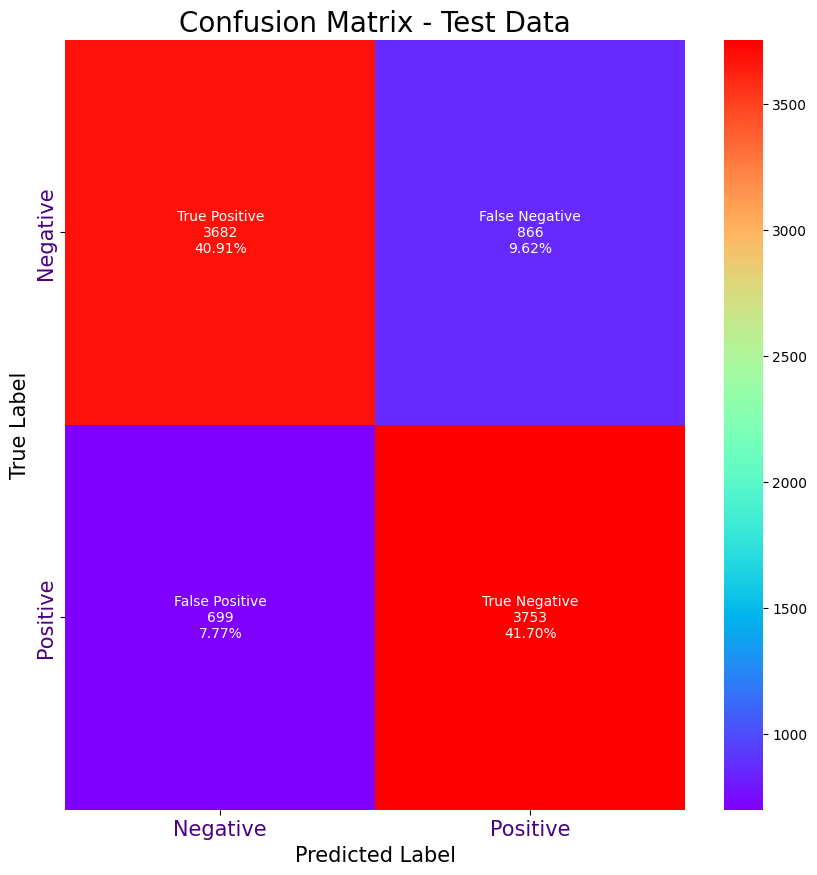

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

              precision    recall  f1-score   support

    Negative       0.84      0.81      0.82      4548
    Positive       0.81      0.84      0.83      4452

    accuracy                           0.83      9000
   macro avg       0.83      0.83      0.83      9000
weighted avg       0.83      0.83      0.83      9000



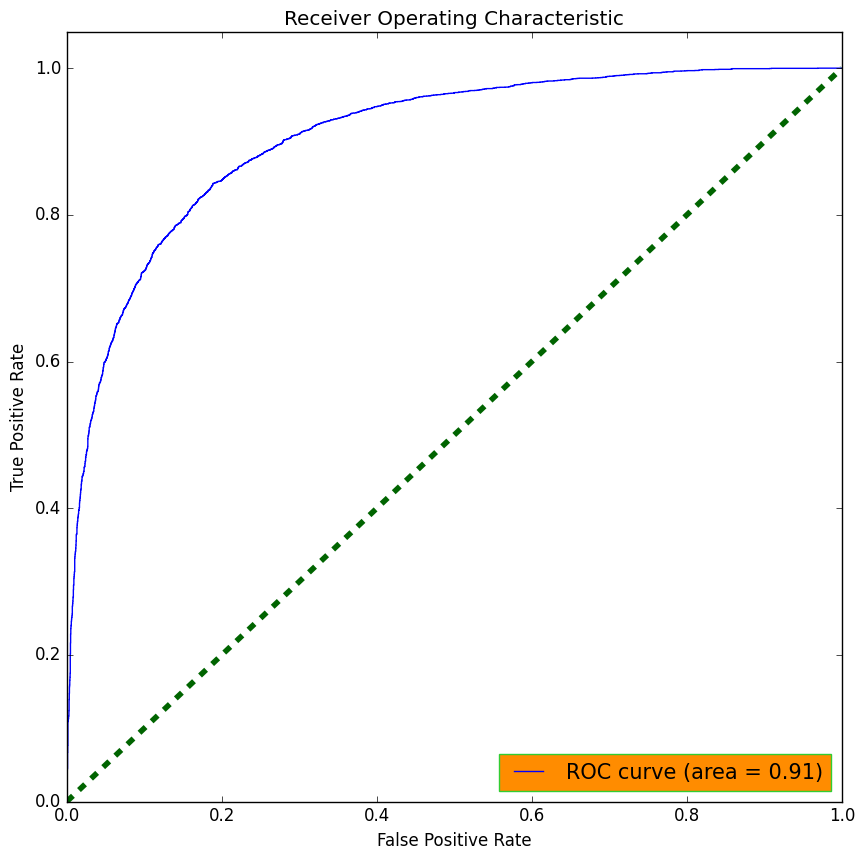

In [43]:
report_results(model,[test_inp,test_mask],test_label,"Confusion Matrix - Test Data")

282/282 [==============================] - 27s 97ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

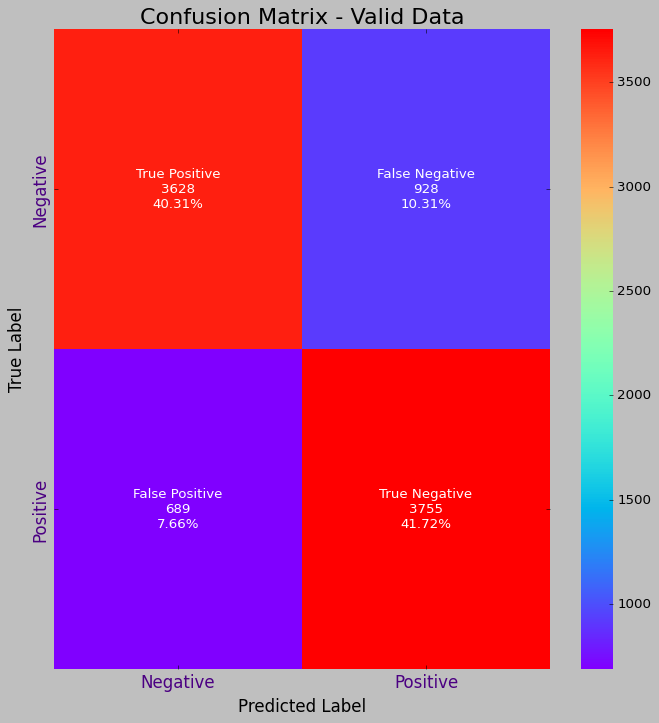

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

              precision    recall  f1-score   support

    Negative       0.84      0.80      0.82      4556
    Positive       0.80      0.84      0.82      4444

    accuracy                           0.82      9000
   macro avg       0.82      0.82      0.82      9000
weighted avg       0.82      0.82      0.82      9000



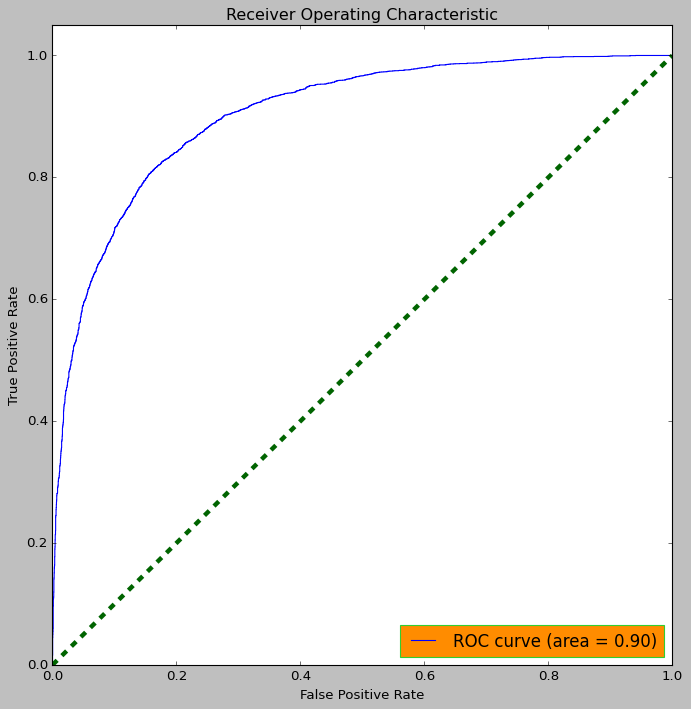

In [44]:
report_results(model,[val_inp,val_mask],val_label,"Confusion Matrix - Valid Data")

1313/1313 [==============================] - 127s 97ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

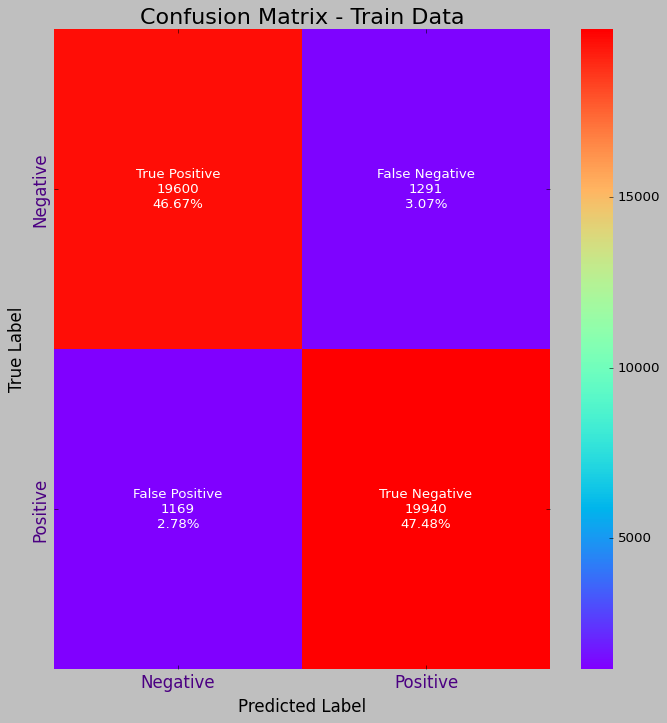

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

              precision    recall  f1-score   support

    Negative       0.94      0.94      0.94     20891
    Positive       0.94      0.94      0.94     21109

    accuracy                           0.94     42000
   macro avg       0.94      0.94      0.94     42000
weighted avg       0.94      0.94      0.94     42000



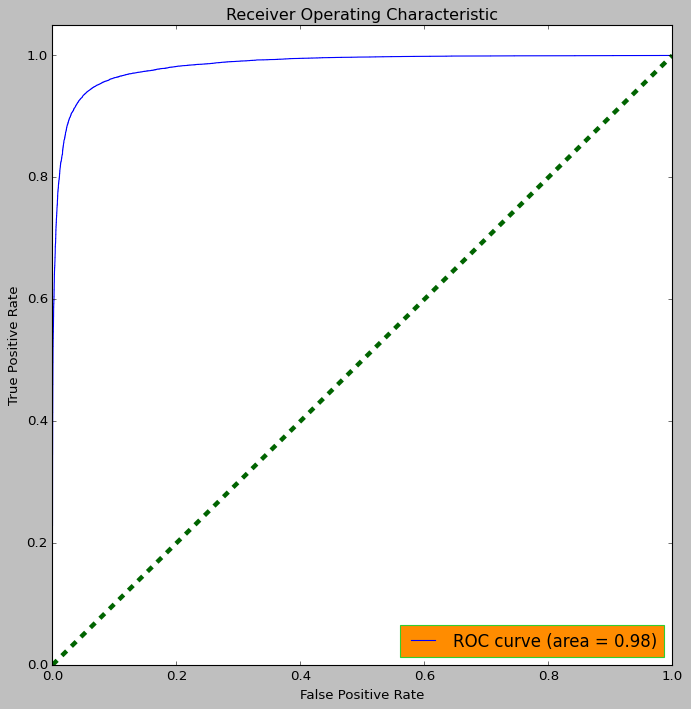

In [45]:
report_results(model,[train_inp,train_mask],train_label,"Confusion Matrix - Train Data")

##  3. Modèle DistilBERT<a class="anchor" id="paragraph3"></a>

In [21]:
dbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')


loading file vocab.txt from cache at C:\Users\doly9/.cache\huggingface\hub\models--distilbert-base-uncased\snapshots\6cdc0aad91f5ae2e6712e91bc7b65d1cf5c05411\vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at C:\Users\doly9/.cache\huggingface\hub\models--distilbert-base-uncased\snapshots\6cdc0aad91f5ae2e6712e91bc7b65d1cf5c05411\tokenizer_config.json
loading file tokenizer.json from cache at C:\Users\doly9/.cache\huggingface\hub\models--distilbert-base-uncased\snapshots\6cdc0aad91f5ae2e6712e91bc7b65d1cf5c05411\tokenizer.json
loading configuration file config.json from cache at C:\Users\doly9/.cache\huggingface\hub\models--distilbert-base-uncased\snapshots\6cdc0aad91f5ae2e6712e91bc7b65d1cf5c05411\config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_d

In [156]:
train_inp,train_mask = model_encode(dbert_tokenizer,X_train,maxlen)
val_inp,val_mask = model_encode(dbert_tokenizer,X_val,maxlen)
test_inp,test_mask = model_encode(dbert_tokenizer,X_test,maxlen)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [157]:
dbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/6cdc0aad91f5ae2e6712e91bc7b65d1cf5c05411/config.json
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.35.0",
  "vocab_size": 30522
}

loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/6cdc0aad91f5ae2e6712e91bc7b65d1cf5c05411/model.safetensors
Loaded 66,362,880 parameters in the TF 2.0 model.
Some weights of the PyTorch model were not used when initializing the TF 2.0 mode

In [21]:
import tensorflow as tf

def create_model_distilbert(dbert_model,max_len):
    # Params
    opt = tf.keras.optimizers.Adam(learning_rate=2e-5)
    loss = tf.keras.losses.BinaryCrossentropy()
    accuracy = tf.keras.metrics.BinaryAccuracy()

    input_ids = tf.keras.Input(shape=(max_len,), dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,), dtype='int32')

    embeddings = dbert_model(input_ids, attention_mask=attention_masks)[0][:,0,:]

    output = tf.keras.layers.Dense(1, activation="sigmoid")(embeddings)

    model = tf.keras.models.Model(inputs=[input_ids, attention_masks], outputs=output)

    model.compile(opt, loss=loss, metrics=[accuracy])

    return model

In [160]:
model = create_model_distilbert(dbert_model,maxlen)
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_33 (InputLayer)       [(None, 70)]                 0         []                            
                                                                                                  
 input_34 (InputLayer)       [(None, 70)]                 0         []                            
                                                                                                  
 tf_distil_bert_model_1 (TF  TFBaseModelOutput(last_hid   6636288   ['input_33[0][0]',            
 DistilBertModel)            den_state=(None, 70, 768),   0          'input_34[0][0]']            
                              hidden_states=None, atten                                           
                             tions=None)                                                   

In [161]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Enregistrez le temps de début
start_time = time.time()

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Define ModelCheckpoint callback to save the best model
checkpoint = ModelCheckpoint('/kaggle/working/best_DistilBERT.h5', monitor='val_loss', save_best_only=True)

# Train the model with EarlyStopping and ModelCheckpoint callbacks
history = model.fit(
    x=[train_inp, train_mask],
    y=train_label,
    validation_data=([val_inp, val_mask], val_label),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, checkpoint]  # Include the callbacks here
)
# Enregistrez le temps de fin
end_time = time.time()

# Calculez la durée totale de l'entraînement
training_time = end_time - start_time
print(f"Temps total d'entraînement du modèle DistilBERT : {training_time} secondes")

Epoch 1/100
1313/1313 [==============================] - ETA: 0s - loss: 0.4403 - binary_accuracy: 0.7953

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1313/1313 [==============================] - 242s 157ms/step - loss: 0.4403 - binary_accuracy: 0.7953 - val_loss: 0.4131 - val_binary_accuracy: 0.8128
Epoch 2/100
1313/1313 [==============================] - 195s 148ms/step - loss: 0.3360 - binary_accuracy: 0.8541 - val_loss: 0.4280 - val_binary_accuracy: 0.8143
Epoch 3/100
1313/1313 [==============================] - 194s 148ms/step - loss: 0.2262 - binary_accuracy: 0.9083 - val_loss: 0.5024 - val_binary_accuracy: 0.8078
Epoch 4/100
1313/1313 [==============================] - 193s 147ms/step - loss: 0.1250 - binary_accuracy: 0.9517 - val_loss: 0.7032 - val_binary_accuracy: 0.7999
Epoch 5/100
1313/1313 [==============================] - 194s 148ms/step - loss: 0.0744 - binary_accuracy: 0.9719 - val_loss: 0.8128 - val_binary_accuracy: 0.8009
Epoch 6/100
1313/1313 [==============================] - 194s 148ms/step - loss: 0.0467 - binary_accuracy: 0.9828 - val_loss: 0.9425 - val_binary_accuracy: 0.7957
Epoch 7/100
1313/1313 [===========

282/282 [==============================] - 15s 48ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

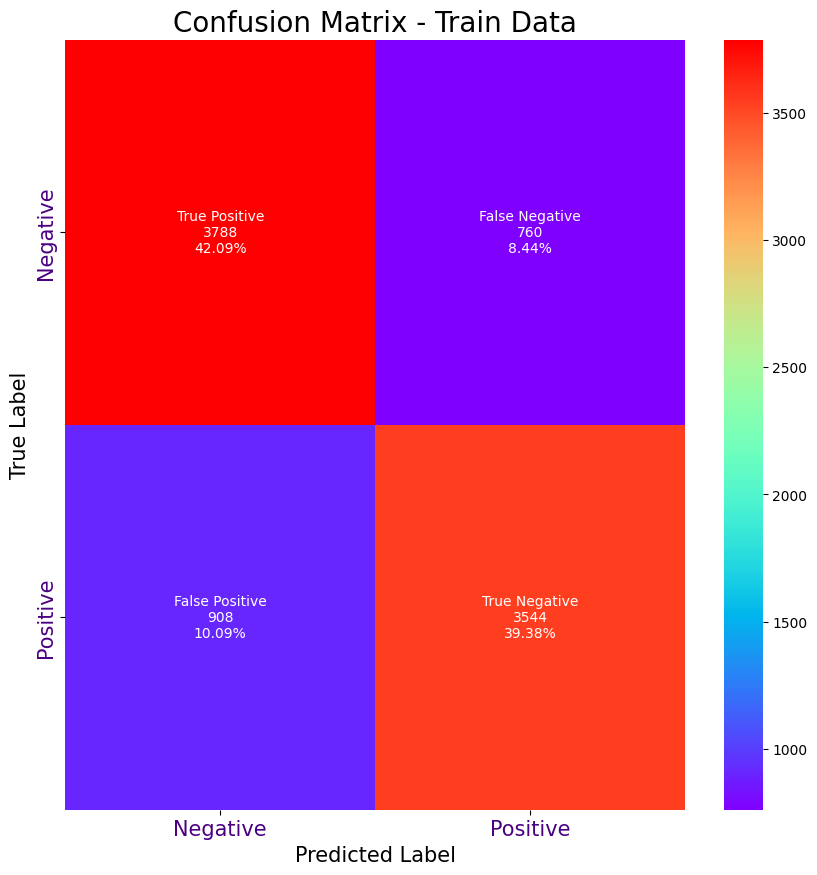

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

              precision    recall  f1-score   support

    Negative       0.81      0.83      0.82      4548
    Positive       0.82      0.80      0.81      4452

    accuracy                           0.81      9000
   macro avg       0.82      0.81      0.81      9000
weighted avg       0.81      0.81      0.81      9000



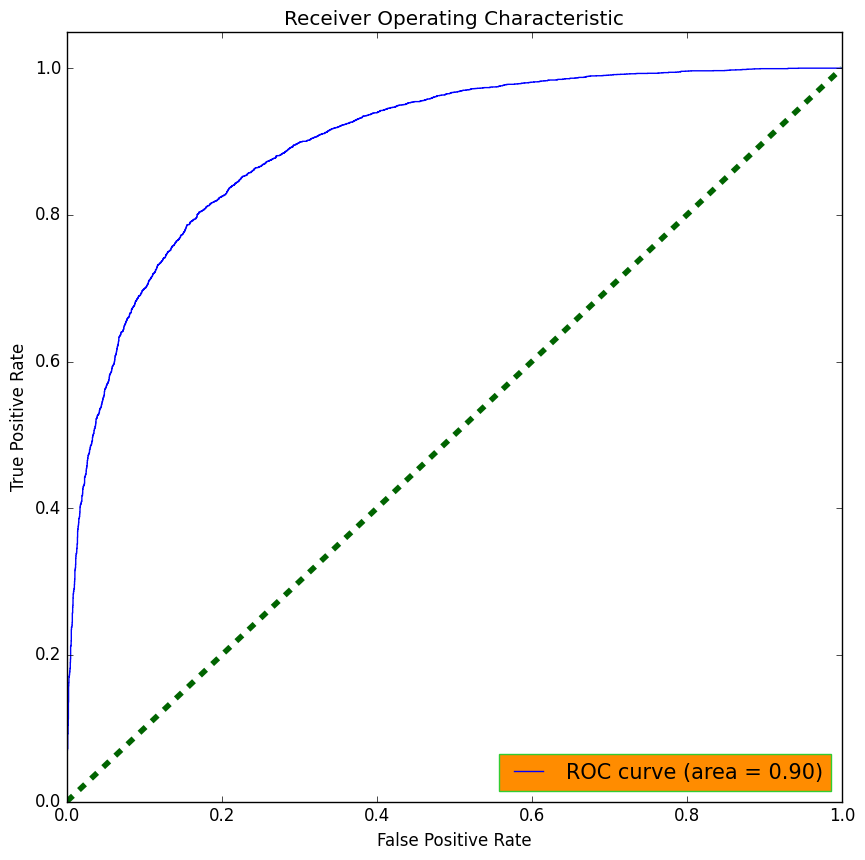

In [162]:
report_results(model,[test_inp,test_mask],test_label,"Confusion Matrix - Train Data")

282/282 [==============================] - 14s 48ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

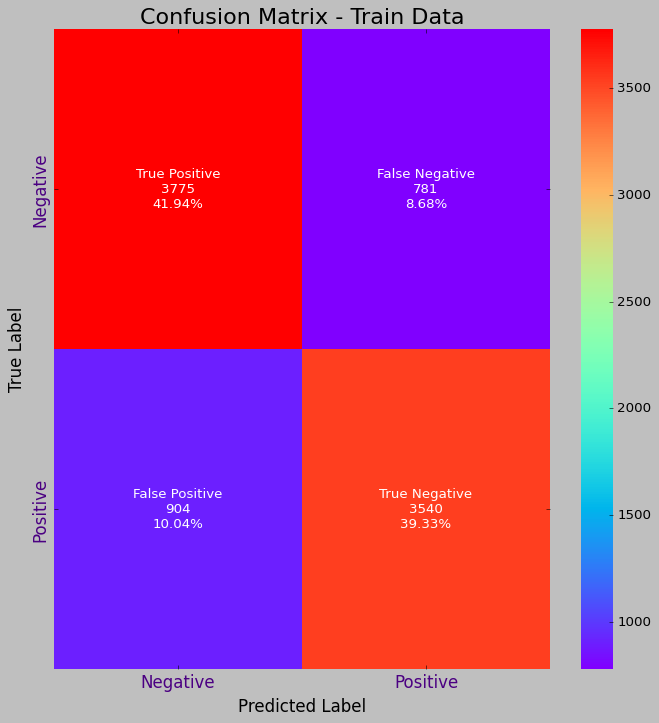

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

              precision    recall  f1-score   support

    Negative       0.81      0.83      0.82      4556
    Positive       0.82      0.80      0.81      4444

    accuracy                           0.81      9000
   macro avg       0.81      0.81      0.81      9000
weighted avg       0.81      0.81      0.81      9000



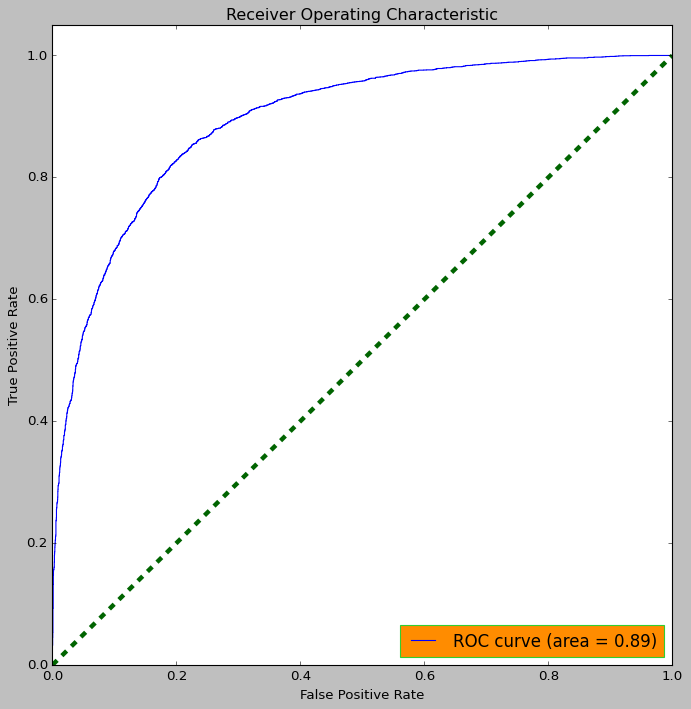

In [163]:
report_results(model,[val_inp,val_mask],val_label,"Confusion Matrix - Train Data")

1313/1313 [==============================] - 63s 48ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

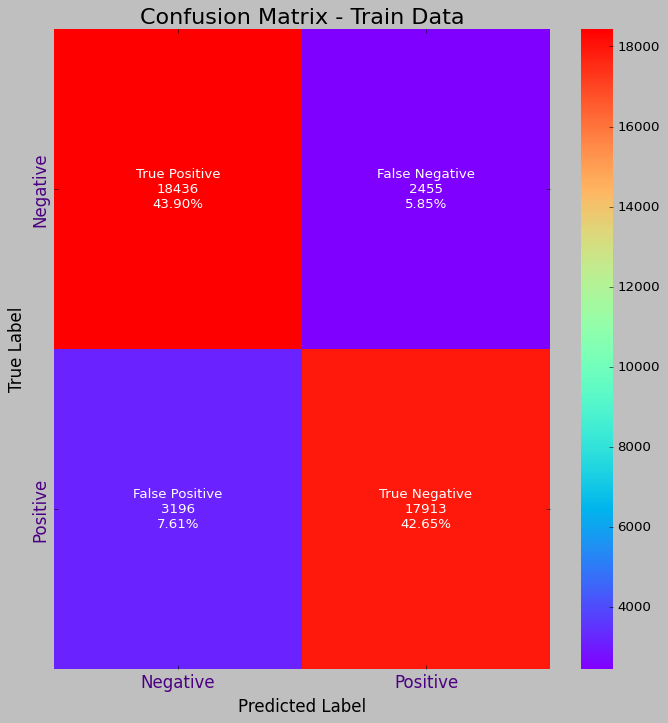

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

              precision    recall  f1-score   support

    Negative       0.85      0.88      0.87     20891
    Positive       0.88      0.85      0.86     21109

    accuracy                           0.87     42000
   macro avg       0.87      0.87      0.87     42000
weighted avg       0.87      0.87      0.87     42000



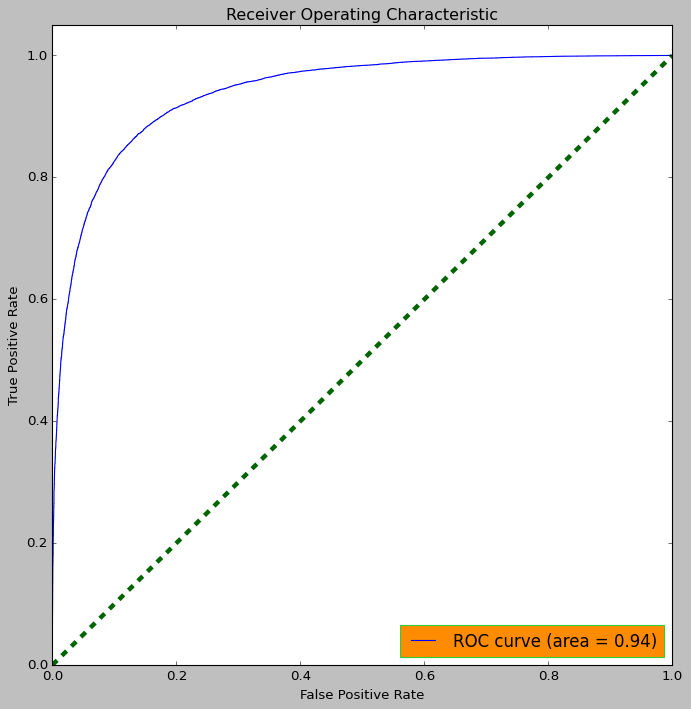

In [164]:
report_results(model,[train_inp,train_mask],train_label,"Confusion Matrix - Train Data")

##  L'interprétabilité locale du modèle avec LIME

In [18]:
# Let's import relevant packages
from lime.lime_text import LimeTextExplainer
from tensorflow.keras.models import load_model
import os, pickle
import numpy as np

In [19]:
# Let's recall the maximum length of tweets
maxlen= 70

In [22]:
# Let's load the model and the tokenizer
dbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
dbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')
model = create_model_distilbert(dbert_model,maxlen)
model.load_weights("model/best_DistilBERT.h5")

loading file vocab.txt from cache at C:\Users\doly9/.cache\huggingface\hub\models--distilbert-base-uncased\snapshots\6cdc0aad91f5ae2e6712e91bc7b65d1cf5c05411\vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at C:\Users\doly9/.cache\huggingface\hub\models--distilbert-base-uncased\snapshots\6cdc0aad91f5ae2e6712e91bc7b65d1cf5c05411\tokenizer_config.json
loading file tokenizer.json from cache at C:\Users\doly9/.cache\huggingface\hub\models--distilbert-base-uncased\snapshots\6cdc0aad91f5ae2e6712e91bc7b65d1cf5c05411\tokenizer.json
loading configuration file config.json from cache at C:\Users\doly9/.cache\huggingface\hub\models--distilbert-base-uncased\snapshots\6cdc0aad91f5ae2e6712e91bc7b65d1cf5c05411\config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_d

We now define the prediction function that LIME will apply on each tweet for interpretability

In [139]:
def predict_sentiment(instances):
    input_ids, masks = model_encode(dbert_tokenizer,instances,maxlen)
    predictions = model.predict([input_ids, masks])
    pred = np.hstack([1 - predictions, predictions])
    return pred

In [140]:
def lime_explain(text):
    exp = explainer.explain_instance(text, predict_sentiment, num_features=10)
    exp.show_in_notebook(text=True)

In [145]:
text_to_explain_1 = "Today is a good day because I am so in love to this guy"
text_to_explain_2 = "It was a quite bad day, poor feeling because I'm sick"

In [142]:
lime_explain(text_to_explain_1)

C:\Users\doly9\anaconda3\envs\envdb\Lib\site-packages\transformers\tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


157/157 [==============================] - 142s 907ms/step
[[0.06813985 0.93186015]
 [0.7092947  0.29070532]
 [0.20608711 0.7939129 ]
 ...
 [0.04421204 0.95578796]
 [0.12029266 0.87970734]
 [0.444372   0.555628  ]]


In [146]:
lime_explain(text_to_explain_2)

C:\Users\doly9\anaconda3\envs\envdb\Lib\site-packages\transformers\tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


157/157 [==============================] - 153s 977ms/step
[[0.9932316  0.00676838]
 [0.99277145 0.00722858]
 [0.46135664 0.53864336]
 ...
 [0.9920197  0.00798028]
 [0.9517256  0.04827441]
 [0.9933582  0.00664183]]


## Global features

In [ ]:
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertModel

# Load pre-trained DistilBERT model and tokenizer
model_name = 'distilbert-base-uncased'

# Example dataset
texts = X_test

# Tokenize and obtain embeddings
tokenized_texts = [dbert_tokenizer.encode(text, add_special_tokens=True, return_tensors='tf') for text in texts]
input_ids, masks = model_encode(dbert_tokenizer,texts,maxlen)

# Assuming input_ids and masks are numpy arrays
batch_size = 8

# Calculate the number of batches
num_samples = len(input_ids)
num_batches = (num_samples + batch_size - 1) // batch_size

# Initialize an empty list to store the last hidden states for each batch
all_last_hidden_states = []

# Process data in batches
for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = (i + 1) * batch_size
    batch_input_ids = input_ids[start_idx:end_idx]
    batch_masks = masks[start_idx:end_idx]

    # Get model activations for the current batch
    with tf.GradientTape() as tape:
        model_output = model([batch_input_ids, batch_masks])
     # Calculate the sum of the output (this is just an example, you can modify it based on your requirements)
        output_sum = tf.reduce_sum(model_output)
    
# Calculate gradients
gradients = tape.gradient(output_sum, [input_ids, masks])

# Calculate feature importance based on the magnitude of gradients
feature_importance = [tf.reduce_sum(tf.abs(gradient)).numpy() for gradient in gradients]


# Visualize feature importance
import matplotlib.pyplot as plt

plt.bar(range(len(texts)), feature_importance)
plt.xticks(range(len(texts)), texts, rotation=45, ha='right')
plt.ylabel('Feature Importance')
plt.xlabel('Texts')
plt.title('Global Feature Importance for DistilBERT')
plt.show()